# Procjena rizika određenog razmještaja podataka

## Ulazni podaci

Ulaz u algoritam su:

* informacije o raspoloživim pružateljima usluga (engl. cloud providers),
* jedna konkretna raspodjela podataka po pružateljima usluga,
* informacije o važnosti podataka.

In [1]:
# Baza pružatelja usluga računarstva u oblaku s njihovim podacima

# Svaki pružatelj usluga ima reputaciju koja ide u rasponu od 0 do 1 pri čemu je 0 bez ikakve reputacije/nepoznato, 1 apsolutno pouzdan. Raspon je asimptotski podijeljen

cloud_providers = {
    "provider1": {
        "reputation": 0.7
    },
    "provider2": {
        "reputation": 0.6
    },
    "provider3": {
        "reputation": 0.5
    },
    "provider4": {
        "reputation": 0.4
    },
    "provider5": {
        "reputation": 0.1
    }
}

U nastavku slijede različite fragmentacije jedne baze. Vrlo je bitno, zbog kasnije implementacije, da se isto ime ne nalazi u različitim tablicama, odnosno, sva imena kolona u tablicama moraju biti jedinstvena u cijeloj bazi!

In [2]:
# Bez fragmentacije

configuration0 = {
    "radno_mjesto": ["vrsta", "satnica", "norma", "dodatak" ],
    "zaposlenik": ["oib", "vrsta", "broj_sati" ]
}

distribution0 = {
    "provider1": [ "radno_mjesto", "zaposlenik" ]
}

In [3]:
# Fragmenti baze podataka za maksimalnu fragmentaciju i raspodjela po pružateljima usluga

configuration1 = {
    "radno_mjesto_1": ["vrsta", "satnica" ],
    "radno_mjesto_2": ["vrsta", "norma"],
    "radno_mjesto_3": ["vrsta", "dodatak"],
    "zaposlenik_1": ["oib", "vrsta"],
    "zaposlenik_2": ["oib", "broj_sati"],
}

distribution1 = {
    "provider1": [ "radno_mjesto_1" ],
    "provider2": [ "radno_mjesto_2" ],
    "provider3": [ "radno_mjesto_3" ],
    "provider4": [ "zaposlenik_1" ],
    "provider5": [ "zaposlenik_2" ],
}

In [4]:
# Fragmenti baze podataka za jednu fragmentaciju

configuration2 = {
    "radno_mjesto_1": ["vrsta", "satnica", "norma"],
    "radno_mjesto_2": ["vrsta", "dodatak"],
    "zaposlenik": ["oib", "vrsta", "broj_sati"]
}

distribution2 = {
    "provider1": [ "radno_mjesto_1" ],
    "provider2": [ "radno_mjesto_2" ],
    "provider3": [ "zaposlenik" ]
}

In [5]:
# Osjetljivost podataka i njihovih kombinacija. Osjetljivost se mjeri na skali od 0 do 1 pri čemu:
#
# 0 -> apsolutno neosjetljivo, 1 -> apsolutno osjetljivo
# raspodjela u intervalu 0 do 1 nije linearna već asimptotska (komprimiran raspon od 0 do beskonačno)
# osjetljivost - sama po sebi - nije apsolutna već relativna (vrijedi samo za jednu specifičnu konfiguraciju)

# Ovo su za sada konkretne vrijednosti. Trebalo bi razmisliti da se ovdje dozvole rasponi (jer je preciznije definirati raspon), a možda i distribucije

# Još jedna napomena. S obzirom da mi imamo raspon od 0 do 1 i asimptotsku raspodjelu unutar tog raspona, to znači da nakon što
# zbrojim dvije vrijednosti moramo ih propustiti kroz nekakvu funkciju (softmax, tanh ili tako nešto slično).

## IMPLEMENTACIJSKI ZAHTJEVI!!!

# 1. Ovdje treba uzeti u obzir da možemo imati 2**N kombinacija ali nam korisnik već neke kombinacije daje. Te kombinacije koje je
#    dao nemaju linearnu zavisnost (drugim riječima, rizik(a) + rizik(b) < rizik(a,b)). Mi ćemo pretpostaviti da kombinacije koje
#    korisnik nije dao imaju linearnu zavisnost za rizik, tj. treba ih samo zbrojiti!
#
# 2. Ova struktura podataka mora biti sortirana po opadajućem broju elemenata u prvoj listi!!

sensitivity = [

    ({ "oib", "vrsta", "norma", "broj_sati", "dodatak" }, 0.83),  # Napadač zna sve. Ima popis zaposlenika, njihova radna mjesta, plaće, dodatke, određen broj sati
    ({ "oib", "vrsta", "norma", "broj_sati" }, 0.81),              # Malo manje zna, sada ne zna dodatak pa ipak nema potpunu plaću
    ({ "oib", "vrsta", "norma" }, 0.8),                            # Sada napadač može samo odrediti s visokom vjerojatnošću i koliko tko zarađuje
    ({ "oib", "vrsta" }, 0.7),                                     # Napadač saznaje popis zaposlenih, njihovo radno mjesto, popis svih radnih mjesta
    
    # Prvo podaci/kolone samo za sebe
    ({ "vrsta" }, 0.5),        # Saznavši sve vrste, napadač može dobiti raspodjelu radnih mjesta u organizaciji
    ({ "satnica" }, 0.4),      # Na temelju satnice može saznati raspodjelu plaća u organizaciji te vjerojatnost da netko ima određenu plaću
    ({ "norma" }, 0.01),          # Za ovo baš i nisam siguran što bi trebalo značiti???
    ({ "dodatak" }, 0.01),        # Dodatak je?
    ({ "oib" }, 0.6),          # Ako se zna popis OIB-a onda se dobija popis zaposlenika, vrlo osjetljiv podatak
    ({ "broj_sati" }, 0.01),      # (PRETPOSTAVLJAM) radi se o broju odrađenih sati po zaposleniku. Množi se sa normom da se dobije plaća plus dodatak na radno mjesto  

]


## Funkcija za određivanje rizika

Kod određivanja rizika možemo pretpostaviti da se kompromitira cijeli pružatelj usluga odjednom! Dakle, svi podaci na jednom pružatelju usluga kompromitirani su odjednom. 

In [6]:
import math

def determine_risk1(configuration, distribution, sensitivity, cloud_providers):
    
    # Start with no risk at all
    aggregate_risk = 0
    
    # S obzirom da pretpostavljamo kako se svi podaci na pružatelju
    # usluga kompromitiraju odjednom, to znači da trebamo ići po
    # pružateljima usluga te gledati koliko podataka se nalazi na
    # pojedinom pružatelju pri čemu uzimamo u obzir osjetljivost
    # grupe podataka.
    for provider in distribution:
        
        # S obzirom da su sve tablice na jednom provideru zajedno, možemo ih
        # spojiti u jedan skup podataka koji se na pružatelju usluga nalazi i
        # potencijalno je kompromitiran
        columns = set()
        for table in distribution[provider]:
            columns.update(configuration[table])
        
        # Sada kada imamo sve kolone na jednom pružatelju usluga, moramo odrediti koliko su ti
        # podaci kritični. U osnovi, polje "sensitivity" nam to govori, pri čemu mi prvo uzimamo
        # najveći podskup iz "sensitivity" te uklonimo sve kolone koje pripadaju tom podskupu
        # iz columns. Zatim ponavljamo postupak dok nam columns ne ostane prazan skup.
        
        while (len(columns)):
            
            for s in sensitivity:
                
                if s[0] <= columns:
                    
                    aggregate_risk += s[1] ** cloud_providers[provider]["reputation"]
                    columns -= s[0]
            
    return math.tanh(aggregate_risk)

In [7]:
import math

def determine_risk2(configuration, distribution, sensitivity, cloud_providers):
    
    # Start with no risk at all
    aggregate_risk = 0
    
    # S obzirom da pretpostavljamo kako se svi podaci na pružatelju
    # usluga kompromitiraju odjednom, to znači da trebamo ići po
    # pružateljima usluga te gledati koliko podataka se nalazi na
    # pojedinom pružatelju pri čemu uzimamo u obzir osjetljivost
    # grupe podataka.
    for provider in distribution:
        
        # S obzirom da su sve tablice na jednom provideru zajedno, možemo ih
        # spojiti u jedan skup podataka koji se na pružatelju usluga nalazi i
        # potencijalno je kompromitiran
        columns = set()
        for table in distribution[provider]:
            columns.update(configuration[table])
        
        # Sada kada imamo sve kolone na jednom pružatelju usluga, moramo odrediti koliko su ti
        # podaci kritični. U osnovi, polje "sensitivity" nam to govori, pri čemu mi prvo uzimamo
        # najveći podskup iz "sensitivity" te uklonimo sve kolone koje pripadaju tom podskupu
        # iz columns. Zatim ponavljamo postupak dok nam columns ne ostane prazan skup.
        
        while (len(columns)):
            
            for s in sensitivity:
                
                if s[0] <= columns:
                    
                    aggregate_risk += 1 / s[1] ** cloud_providers[provider]["reputation"]
                    columns -= s[0]
            
    return 1 / aggregate_risk

## Eksperimenti nad ulaznim podacima

### Slučaj 1: Svi podaci na jednom pružatelju usluga.

Rizik ovdje ovisi samo o pouzdanosti pružatelja usluga na kojemu su podaci smješteni. Prema tome, ako se variraju pružatelji usluga, rizik se mora mijenjati.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

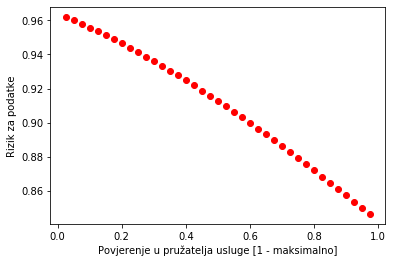

In [9]:
# Određivanje rizika kada su podaci na jednom pružatelju usluga

STEPS=40

x = []
y = []
for r in range(1,STEPS):
    x.append(r/STEPS)
    y.append(determine_risk1(configuration0, distribution0, sensitivity, { "provider1": { "reputation": r/STEPS } }))
    
plt.plot(x,y,'ro')
plt.xlabel("Povjerenje u pružatelja usluge [1 - maksimalno]")
plt.ylabel("Rizik za podatke")
plt.show()

Funkcija ima dobar trend, rizik se smanjuje kako povjerenje u pružatelja usluge raste. Međutim, kada se apsolutno vjeruje pružatelju usluge, tada bi rizik trebao biti nula ili vrlo blizu nule - što u ovom slučaju nije.

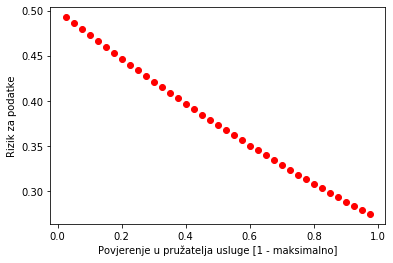

In [10]:
# Određivanje rizika kada su podaci na jednom pružatelju usluga

STEPS=40

x = []
y = []
for r in range(1,STEPS):
    x.append(r/STEPS)
    y.append(determine_risk2(configuration0, distribution0, sensitivity, { "provider1": { "reputation": r/STEPS } }))
    
plt.plot(x,y,'ro')
plt.xlabel("Povjerenje u pružatelja usluge [1 - maksimalno]")
plt.ylabel("Rizik za podatke")
plt.show()

#### Komentar na graf funkcije

Funkcija ima dobar trend, kako raste povjerenje u pružatelja usluge tako i opada rizik za podatke. Međutim, kako povjerenje u pružatelja usluge pada tako bi rizik za podatke trebao biti bliži jedinici!

In [11]:
# Određivanje rizika kada su podaci svaki na svom pružatelju usluga

print(determine_risk2(configuration1, distribution1, sensitivity, cloud_providers))

# Određivanje rizika kada su podaci na dva pružatelju usluga

print(determine_risk2(configuration2, distribution2, sensitivity, cloud_providers))

0.02770607798207826
0.017481786826165188


Rizik je u slučaju kada se koristi manje pružatelja usluga manji! Što se čini pogrešnim. Međutim, ne mora nužno biti jer jako ovisi kako su osjetljivi podaci raspodijeljeni. Moguće je da su za manji broj pružatelja usluga korišteni kvalitetniji pružatelji usluga, dok u slučaju većeg broja pružatelja usluga podaci završe na osjetljivijem mjestu.